# Code for SwDS dissertation 2
#### This file contains code for the deep learning models (Section 3)

#### Yilun Dong (s1994256), August/2020


Notes:

1. This code was ran on GPU on my laptop, so the results displayed here may not be exactly the same as the results displayed in the report.

2. Please download "glove.6B.100d.txt" from https://nlp.stanford.edu/projects/glove/ and configure the directory before running the code. This file is used in block 8.

In [1]:
import re
import string
import nltk
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Input, layers
from keras.utils import plot_model
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score, auc

Using TensorFlow backend.


In [2]:
# original data frames from the csv file
train_original = pd.read_csv('quora_train.csv')
test_original = pd.read_csv('quora_test.csv')

In [3]:
# drop nan rows
train = train_original.drop([train_original.index[182601] , train_original.index[219751]])
test = test_original.drop([test_original.index[1495]])

print('The length of the training data is', len(train))
print('The length of the test data is', len(test))

The length of the training data is 323478
The length of the test data is 80870


In [4]:
# drop question ID and pairing ID
train = train.drop(train_original.columns[[0,1,2,3]], axis=1)
test = test.drop(test_original.columns[[0,1,2,3]], axis=1)

# Text pre-processing

In [5]:
# define punctuation, stemmer and stop words
punctuation = string.punctuation
stemmer_sb = nltk.stem.SnowballStemmer('english')
stop_words = set(nltk.corpus.stopwords.words('english'))

def replaceNumbers(text):
    '''
    This function replaces numbers with words with space. For example, `100` would be replaced by `one zero zero`.
    '''
    scheme = {
        '0': 'zero',
        '1': 'one',
        '2': 'two',
        '3': 'three',
        '4': 'four',
        '5': 'five',
        '6': 'six',
        '7': 'seven',
        '8': 'eight',
        '9': 'nine'
    }
    for character, replacement in scheme.items():
        text = text.replace(character, ' ' + replacement + ' ')
    return text

def textCleaner(text, stemming = True):
    '''
    This function:
    1. substitutes punctuation defined above with blank space;
    2. strips the text and convert the letters to lower case;
    3. extracts the stems of the words in the text using stemmer defined above if `stemming = True`;
    4. removes the stop words defined above.
    '''
    text = re.sub(r'[{}]+'.format(punctuation), ' ' , text)
    text = text.strip().lower()
    text = replaceNumbers(text)
    word_list = nltk.word_tokenize(text)
    if stemming == True:
        word_list = list(map(stemmer_sb.stem, word_list))
        word_list = [word for word in word_list if not word in stop_words]
    else:
        word_list = [word for word in word_list if not word in stop_words]
    new_text = ' '.join(word_list)
    return new_text

In [6]:
train['question1_stemmed'] = train['question1'].apply(textCleaner)
train['question2_stemmed'] = train['question2'].apply(textCleaner)
train['question1_notStemmed'] = train['question1'].apply(lambda x: textCleaner(x, stemming = False))
train['question2_notStemmed'] = train['question2'].apply(lambda x: textCleaner(x, stemming = False))
train

,question1,question2,is_duplicate,question1_stemmed,question2_stemmed,question1_notStemmed,question2_notStemmed
0,How does banning 500 & 1000 rupee notes solve ...,Will the ban on 500 & 1000 rupee notes really ...,1,doe ban five zero zero one zero zero zero rupe...,ban five zero zero one zero zero zero rupe not...,banning five zero zero one zero zero zero rupe...,ban five zero zero one zero zero zero rupee no...
1,What is the hardest thing(s) about raising chi...,What is the hardest thing(s) about raising chi...,0,hardest thing rais children georgia,hardest thing rais children mexico,hardest thing raising children georgia,hardest thing raising children mexico
2,Who are Utopia's top competitors?,Who are Axis 41's top competitors?,0,utopia top competitor,axi four one top competitor,utopia top competitors,axis four one top competitors
3,I want to improve my reading skill by reading ...,How can reading newspaper help me improve my E...,0,want improv read skill read english news everi...,read newspap help improv english,want improve reading skill reading english new...,reading newspaper help improve english
4,How do I gain weight in naturally way?,How to gain weight ?,1,gain weight natur way,gain weight,gain weight naturally way,gain weight
...,...,...,...,...,...,...,...
323475,"Who will win, Trump or Clinton?","Who will be indicted first, Trump or Clinton?",0,win trump clinton,indict first trump clinton,win trump clinton,indicted first trump clinton
323476,Which is the best earphone under 1000rs?,What is the best earphone under 1000 rs?,1,best earphon one zero zero zero rs,best earphon one zero zero zero rs,best earphone one zero zero zero rs,best earphone one zero zero zero rs
323477,What songs make you cry and why?,Which songs did make you cry ever?,1,song make cri whi,song make cri ever,songs make cry,songs make cry ever
323478,Taste of sperm?,What is the taste of sperm?,1,tast sperm,tast sperm,taste sperm,taste sperm


In [7]:
test['question1_stemmed'] = test['question1'].apply(textCleaner)
test['question2_stemmed'] = test['question2'].apply(textCleaner)
test['question1_notStemmed'] = test['question1'].apply(lambda x: textCleaner(x, stemming = False))
test['question2_notStemmed'] = test['question2'].apply(lambda x: textCleaner(x, stemming = False))
test

,question1,question2,is_duplicate,question1_stemmed,question2_stemmed,question1_notStemmed,question2_notStemmed
0,What are the pros and cons of Legalzoom-genera...,Where can I read reviews of LegalZoom?,0,pros con legalzoom generat,read review legalzoom,pros cons legalzoom generated wills,read reviews legalzoom
1,Why does ready-to-eat poha absorb water instan...,Ultimate teen patti hacker?,0,whi doe readi eat poha absorb water instant,ultim teen patti hacker,ready eat poha absorb water instantly,ultimate teen patti hacker
2,How apps like paytm earn profit when they are ...,How does Paytm earn by giving extra cash back ...,1,app like paytm earn profit give mani cash back...,doe paytm earn give extra cash back alreadi di...,apps like paytm earn profit giving many cash b...,paytm earn giving extra cash back already disc...
3,What daily habits can greatly upgrade life?,What are your daily habits that improve your p...,1,daili habit great upgrad life,daili habit improv product creativ,daily habits greatly upgrade life,daily habits improve productivity creativity
4,What video game world would you want to live in?,"If you could live in any video game setting, w...",1,video game world would want live,could live ani video game set would live whi,video game world would want live,could live video game setting would live
...,...,...,...,...,...,...,...
80866,What is your favourite Beatles song and why do...,What is your favorite Beatles song? And why do...,1,favourit beatl song whi like,favorit beatl song whi like,favourite beatles song like,favorite beatles song like
80867,Who has the legal authority to rule China's cl...,How can I prove that every bounded and monoton...,0,legal author rule china claim eight five south...,prove everi bound monoton increas sequenc conv...,legal authority rule china claim eight five so...,prove every bounded monotonically increasing s...
80868,What are the best simulator games for android?,Which are some best simulator games on android?,1,best simul game android,best simul game android,best simulator games android,best simulator games android
80869,How can some people still believe the world is...,Why do some people currently believe the earth...,1,peopl still believ world flat,whi peopl current believ earth flat,people still believe world flat,people currently believe earth flat


In [8]:
# read GloVe file
embeddings_index = {}
f = open('D:/Anaconda3/glove.6B/glove.6B.100d.txt', encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

def getGloveMatrix (max_words, embedding_dim, word_index):
    '''
    This function returns the embedding matrix of text data using the pre-trained GloVe data set.
    '''
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [9]:
maxlen = 100
max_words = 10000
embedding_dim = 100

# training data, test data and the embedding matrix of stemmed words
fullTextSeries_stemmed_train = train['question1_stemmed'].append(train['question2_stemmed'])
fullTextSeries_stemmed_test = test['question1_stemmed'].append(test['question2_stemmed'])

tokenizer_stemmed = Tokenizer(num_words = max_words)
tokenizer_stemmed.fit_on_texts(fullTextSeries_stemmed_train)
word_index_stemmed = tokenizer_stemmed.word_index

stemmed_train_sequences = pad_sequences(tokenizer_stemmed.texts_to_sequences(fullTextSeries_stemmed_train), maxlen)
stemmed_test_sequences = pad_sequences(tokenizer_stemmed.texts_to_sequences(fullTextSeries_stemmed_test), maxlen)
                                       
x1_stemmed_train = stemmed_train_sequences[0:len(train)]
print('Shape of training X:', len(x1_stemmed_train))
x2_stemmed_train = stemmed_train_sequences[len(train):]
print('Shape of training y:', len(x2_stemmed_train))
x1_stemmed_test = stemmed_test_sequences[0:len(test)]
print('Shape of test X:', len(x1_stemmed_test))
x2_stemmed_test = stemmed_test_sequences[len(test):]
print('Shape of test y:', len(x2_stemmed_test))

embedding_matrix_stemmed = getGloveMatrix(max_words, embedding_dim, word_index_stemmed)

# training data, test data and the embedding matrix of original words (analogous to the code above)
fullTextSeries_notStemmed_train = train['question1_notStemmed'].append(train['question2_notStemmed'])
fullTextSeries_notStemmed_test = test['question1_notStemmed'].append(test['question2_notStemmed'])

tokenizer_notStemmed = Tokenizer(num_words = max_words)
tokenizer_notStemmed.fit_on_texts(fullTextSeries_notStemmed_train)
word_index_notStemmed = tokenizer_notStemmed.word_index

notStemmed_train_sequences = pad_sequences(tokenizer_notStemmed.texts_to_sequences(fullTextSeries_notStemmed_train), maxlen)
notStemmed_test_sequences = pad_sequences(tokenizer_notStemmed.texts_to_sequences(fullTextSeries_notStemmed_test), maxlen)
                                       
x1_notStemmed_train = notStemmed_train_sequences[0:len(train)]
print('Shape of training X:', len(x1_notStemmed_train))
x2_notStemmed_train = notStemmed_train_sequences[len(train):]
print('Shape of training y:', len(x2_notStemmed_train))
x1_notStemmed_test = notStemmed_test_sequences[0:len(test)]
print('Shape of test X:', len(x1_notStemmed_test))
x2_notStemmed_test = notStemmed_test_sequences[len(test):]
print('Shape of test y:', len(x2_notStemmed_test))

embedding_matrix_notStemmed = getGloveMatrix(max_words, embedding_dim, word_index_notStemmed)

# training and test labels
labels_train = np.asarray(train['is_duplicate'].to_list())
print('Shape of training labels:', labels_train.shape)

labels_test = np.asarray(test['is_duplicate'].to_list())
print('Shape of test labels:', labels_test.shape)

Shape of training X: 323478
Shape of training y: 323478
Shape of test X: 80870
Shape of test y: 80870
Shape of training X: 323478
Shape of training y: 323478
Shape of test X: 80870
Shape of test y: 80870
Shape of training labels: (323478,)
Shape of test labels: (80870,)


In [10]:
# splitting training data into training and validation sets
x1_stemmed_train_split = x1_stemmed_train[0:300000]
x1_stemmed_val_split = x1_stemmed_train[300000:]
x2_stemmed_train_split = x2_stemmed_train[0:300000]
x2_stemmed_val_split = x2_stemmed_train[300000:]

x1_notStemmed_train_split = x1_notStemmed_train[0:300000]
x1_notStemmed_val_split = x1_notStemmed_train[300000:]
x2_notStemmed_train_split = x2_notStemmed_train[0:300000]
x2_notStemmed_val_split = x2_notStemmed_train[300000:]

labels_train_split = labels_train[0:300000]
labels_val_split = labels_train[300000:]

In [11]:
class customMetrics(tf.keras.callbacks.Callback):
    '''
    This is a custom metric which is accessible using the keras Callback function. 
    This metric saves and prints the F1 score, precision and recall of the validation data after each epoch.
    The metrics are calculated using functions from `scikit-learn`.
    '''
    def __init__(self, validation):   
        super(customMetrics, self).__init__()
        self.validation = validation 
        
    def on_train_begin(self, logs={}):        
        self.f1_scores = []
        self.precisions = []
        self.recalls = []
     
    def on_epoch_end(self, epoch, logs={}):
        true_lebels = self.validation[1]   
        predictions = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        f1_score_epoch = f1_score(true_lebels, predictions, average = 'macro')
        precision_epoch = precision_score(true_lebels, predictions)
        recall_epoch = recall_score(true_lebels, predictions)                 
        
        self.f1_scores.append(f1_score_epoch)
        self.precisions.append(precision_epoch)
        self.recalls.append(recall_epoch)
 
        print('For this epoch:', '\nMacro F1 score:', f1_score_epoch, '---Precision:', precision_epoch, '---Recall:', recall_epoch)

In [12]:
def lossPlot(history):
    '''
    This function plots the line chart of the validation loss during the training process.
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Note

Please note that the warning " Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory" during some compiling processes is produced by the optimizer `keras.optimizers.RMSprop()` itself and this warning does not influence the result.

Using another optimizer `tf.keras.optimizers.RMSprop()` can supress this warning. However, it will bring up another warning:

"TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers)."

The third option of writing the optimizer is wrapping with `keras.optimizers.TFOptimizer(tf.keras.optimizers.RMSprop())`, which gives the same warning message as that in the second option.

References: 

https://github.com/keras-team/keras/issues/4365#issuecomment-260482550

https://github.com/horovod/horovod/issues/42

In [13]:
# the early stopping callback feature to be used
stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

# To save space, two helper functions will be used during model development.
def modelCompiler(model, checkpoint, x_train, y_train, x_val, y_val):
    '''
    This function compiles and fits a model, then returns its history.
    '''
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = [])
    history = model.fit(x_train, y_train, epochs = 40, batch_size = 300,
                        validation_data = (x_val, y_val),
                        callbacks = [customMetrics(validation=(x_val, y_val)),
                                     checkpoint,
                                     stopping])
    print('Training complete')
    return history

def modelTester(model_name, x_test, y_test):
    '''
    The function tests a model by calculating its classification report, confusion matrix and loss plot.
    '''
    model_trained = tf.keras.models.load_model(model_name)
    model_pred = model_trained.predict(x_test).round()
    print(classification_report(y_test, model_pred))
    print(confusion_matrix(y_test, model_pred))
    
    return classification_report(y_test, model_pred), confusion_matrix(y_test, model_pred)

# Model 1

In [14]:
def buildModel_1(embedding_weights, trainable = True):
    
    embedding = layers.Embedding(max_words, embedding_dim, input_length = maxlen, name = 'Siamese_Embedding')
    flat = layers.Flatten(name = 'Siamese_Flatten')
    dense = layers.Dense(16, activation = 'relu', name = 'Siamese_Dense')
    
    q1_input = Input(shape = (maxlen, ), dtype = 'int32', name = 'q1_input')
    q1_embedded = embedding(q1_input)
    q1_flat = flat(q1_embedded)
    q1_dense = dense(q1_flat)
    q1_output = q1_dense

    q2_input = Input(shape = (maxlen, ), dtype = 'int32', name = 'q2_input')
    q2_embedded = embedding(q2_input)
    q2_flat = flat(q2_embedded)
    q2_dense = dense(q2_flat)
    q2_output = q2_dense

    concatenated = layers.concatenate([q1_output, q2_output], axis = -1, name = 'Concatenation')
    y = layers.Dense(1, activation = 'sigmoid', name = 'Concatenated_Dense')(concatenated)

    model = Model([q1_input, q2_input], y)
    
    model.layers[2].set_weights([embedding_weights])
    
    if trainable == False:
        model.layers[2].trainable = False
        
    return model
    
buildModel_1(embedding_weights = embedding_matrix_stemmed).summary()
# plot_model(buildModel_1(embedding_matrix_notStemmed))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_input (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
q2_input (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
Siamese_Embedding (Embedding)   (None, 100, 100)     1000000     q1_input[0][0]                   
                                                                 q2_input[0][0]                   
__________________________________________________________________________________________________
Siamese_Flatten (Flatten)       (None, 10000)        0           Siamese_Embedding[0][0]    

## Model 1.1: 'trainable = False' + notStemmed data

Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 7s 24us/step - loss: 0.5810 - val_loss: 0.5607
For this epoch: 
Macro F1 score: 0.6465058438284412 ---Precision: 0.7159260046778652 ---Recall: 0.38062401085236264
Epoch 2/40
300000/300000 [==============================] - 4s 12us/step - loss: 0.5493 - val_loss: 0.5454
For this epoch: 
Macro F1 score: 0.6780853931956639 ---Precision: 0.6905747888023853 ---Recall: 0.4712864571557766
Epoch 3/40
300000/300000 [==============================] - 4s 12us/step - loss: 0.5340 - val_loss: 0.5398
For this epoch: 
Macro F1 score: 0.6899848875778172 ---Precision: 0.684250532076619 ---Recall: 0.5088175446529505
Epoch 4/40
300000/300000 [==============================] - 4s 12us/step - loss: 0.5238 - val_loss: 0.5389
For this epoch: 
Macro F1 score: 0.6917033264208831 ---Precision: 0.6853643785908679 ---Recall: 0.5124349988695456
Epoch 5/40
300000/300000 [==============================] - 4

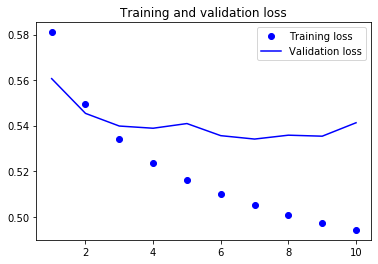

In [15]:
np.random.seed(1)
tf.random.set_seed(1)
model_1_1 = buildModel_1(embedding_matrix_notStemmed, trainable = False)

checkpoint_1_1 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_1_1.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_1_1 = modelCompiler(model_1_1, checkpoint_1_1,
                            [x1_notStemmed_train_split, x2_notStemmed_train_split], labels_train_split,
                            [x1_notStemmed_val_split, x2_notStemmed_val_split], labels_val_split)

result_1_1 = modelTester('model_1_1.h5', [x1_notStemmed_test, x2_notStemmed_test], labels_test)

lossPlot(history_1_1)

## Model 1.2: 'trainable = False' + stemmed data

Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 4s 13us/step - loss: 0.5876 - val_loss: 0.5724
For this epoch: 
Macro F1 score: 0.6253899133173646 ---Precision: 0.711068973690448 ---Recall: 0.3391363328057879
Epoch 2/40
300000/300000 [==============================] - 4s 12us/step - loss: 0.5581 - val_loss: 0.5542
For this epoch: 
Macro F1 score: 0.667461335673059 ---Precision: 0.6853195164075994 ---Recall: 0.44856432285778886
Epoch 3/40
300000/300000 [==============================] - 4s 12us/step - loss: 0.5418 - val_loss: 0.5477
For this epoch: 
Macro F1 score: 0.6789442275963364 ---Precision: 0.6910501981505944 ---Recall: 0.47309518426407415
Epoch 4/40
300000/300000 [==============================] - 4s 12us/step - loss: 0.5308 - val_loss: 0.5455
For this epoch: 
Macro F1 score: 0.6853578968257283 ---Precision: 0.6904345058093267 ---Recall: 0.4903911372371693
Epoch 5/40
300000/300000 [==============================] - 4

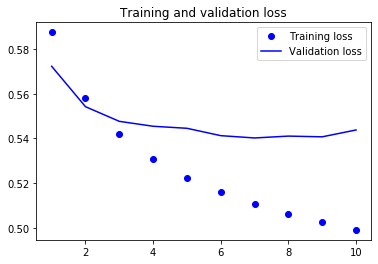

In [16]:
np.random.seed(1)
tf.random.set_seed(1)
model_1_2 = buildModel_1(embedding_matrix_stemmed, trainable = False)

checkpoint_1_2 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_1_2.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_1_2 = modelCompiler(model_1_2, checkpoint_1_2,
                            [x1_stemmed_train_split, x2_stemmed_train_split], labels_train_split,
                            [x1_stemmed_val_split, x2_stemmed_val_split], labels_val_split)

result_1_2 = modelTester('model_1_2.h5', [x1_stemmed_test, x2_stemmed_test], labels_test)

lossPlot(history_1_2)

## Model 1.3: 'trainable = True' + notStemmed data

D:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 8s 27us/step - loss: 0.5509 - val_loss: 0.5206
For this epoch: 
Macro F1 score: 0.7024110800230297 ---Precision: 0.7334666000333167 ---Recall: 0.4977390911146281
Epoch 2/40
300000/300000 [==============================] - 8s 26us/step - loss: 0.5024 - val_loss: 0.5067
For this epoch: 
Macro F1 score: 0.7186357473913647 ---Precision: 0.7360012408872344 ---Recall: 0.5364006330544879
Epoch 3/40
300000/300000 [==============================] - 8s 26us/step - loss: 0.4785 - val_loss: 0.5022
For this epoch: 
Macro F1 score: 0.7277434842546431 ---Precision: 0.7290303823230121 ---Recall: 0.5669229030070089
Epoch 4/40
300000/300000 [==============================] - 8s 26us/step - loss: 0.4585 - val_loss: 0.5020
For this epoch: 
Macro F1 score: 0.7322410542846607 ---Precision: 0.7014267185473411 ---Recall: 0.6113497626045671
Epoch 5/40
300000/300000 [==============================] - 8

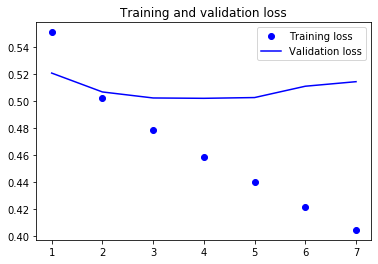

In [17]:
np.random.seed(1)
tf.random.set_seed(1)
model_1_3 = buildModel_1(embedding_matrix_notStemmed, trainable = True)

checkpoint_1_3 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_1_3.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_1_3 = modelCompiler(model_1_3, checkpoint_1_3,
                            [x1_notStemmed_train_split, x2_notStemmed_train_split], labels_train_split,
                            [x1_notStemmed_val_split, x2_notStemmed_val_split], labels_val_split)

result_1_3 = modelTester('model_1_3.h5', [x1_notStemmed_test, x2_notStemmed_test], labels_test)

lossPlot(history_1_3)

## Model 1.4: 'trainable = True' + stemmed data

D:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 8s 27us/step - loss: 0.5531 - val_loss: 0.5235
For this epoch: 
Macro F1 score: 0.6997834047008873 ---Precision: 0.7414954239336902 ---Recall: 0.48541713768935113
Epoch 2/40
300000/300000 [==============================] - 8s 26us/step - loss: 0.5046 - val_loss: 0.5078
For this epoch: 
Macro F1 score: 0.7185139222225099 ---Precision: 0.7431832593532023 ---Recall: 0.5299570427311779
Epoch 3/40
300000/300000 [==============================] - 8s 26us/step - loss: 0.4812 - val_loss: 0.5037
For this epoch: 
Macro F1 score: 0.7302951952624268 ---Precision: 0.7197825177749896 ---Recall: 0.583653628758761
Epoch 4/40
300000/300000 [==============================] - 8s 26us/step - loss: 0.4612 - val_loss: 0.5027
For this epoch: 
Macro F1 score: 0.7293696408165226 ---Precision: 0.7173218502569801 ---Recall: 0.5837666742030296
Epoch 5/40
300000/300000 [==============================] - 8

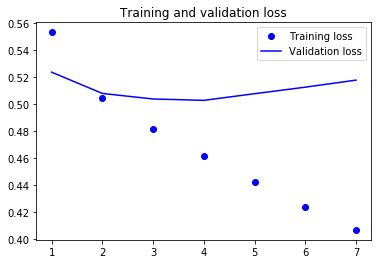

In [18]:
np.random.seed(1)
tf.random.set_seed(1)
model_1_4 = buildModel_1(embedding_matrix_stemmed, trainable = True)

checkpoint_1_4 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_1_4.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_1_4 = modelCompiler(model_1_4, checkpoint_1_4,
                            [x1_stemmed_train_split, x2_stemmed_train_split], labels_train_split,
                            [x1_stemmed_val_split, x2_stemmed_val_split], labels_val_split)

result_1_4 = modelTester('model_1_4.h5', [x1_stemmed_test, x2_stemmed_test], labels_test)

lossPlot(history_1_4)

In [19]:
# Calculate the results and plot the P-R curves.
# Please note that the AUC values on the P-R curves are manully added.
model_1_1_trained = tf.keras.models.load_model('model_1_1.h5')
labels_pred_1_1 = model_1_1_trained.predict([x1_notStemmed_test, x2_notStemmed_test])
precision_1_1, recall_1_1, thresholds_1_1 = precision_recall_curve(labels_test, labels_pred_1_1)

model_1_2_trained = tf.keras.models.load_model('model_1_2.h5')
labels_pred_1_2 = model_1_2_trained.predict([x1_stemmed_test, x2_stemmed_test])
precision_1_2, recall_1_2, thresholds_1_2 = precision_recall_curve(labels_test, labels_pred_1_2)

model_1_3_trained = tf.keras.models.load_model('model_1_3.h5')
labels_pred_1_3 = model_1_3_trained.predict([x1_notStemmed_test, x2_notStemmed_test])
precision_1_3, recall_1_3, thresholds_1_3 = precision_recall_curve(labels_test, labels_pred_1_3)

model_1_4_trained = tf.keras.models.load_model('model_1_4.h5')
labels_pred_1_4 = model_1_4_trained.predict([x1_stemmed_test, x2_stemmed_test])
precision_1_4, recall_1_4, thresholds_1_4 = precision_recall_curve(labels_test, labels_pred_1_4)

In [20]:
print(auc(recall_1_1, precision_1_1))
print(auc(recall_1_2, precision_1_2))
print(auc(recall_1_3, precision_1_3))
print(auc(recall_1_4, precision_1_4))

0.69949589232873
0.6914509799259277
0.7491771553307409
0.7472942360371728


D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


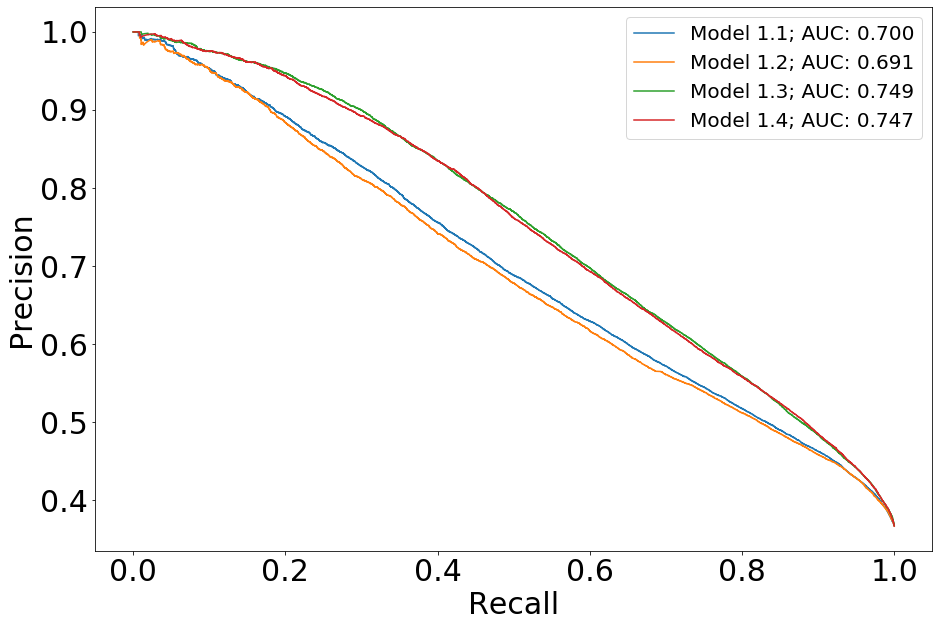

In [21]:
plt.figure(figsize = (15, 10))
plt.plot(recall_1_1, precision_1_1, label = 'Model 1.1; AUC: 0.700')
plt.plot(recall_1_2, precision_1_2, label = 'Model 1.2; AUC: 0.691')
plt.plot(recall_1_3, precision_1_3, label = 'Model 1.3; AUC: 0.749')
plt.plot(recall_1_4, precision_1_4, label = 'Model 1.4; AUC: 0.747')
plt.xlabel('Recall', fontsize = 30)
plt.ylabel('Precision',  fontsize = 30)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.show()

# Model 2

In [22]:
def buildModel_2(embedding_weights, trainable = True):
    embedding = layers.Embedding(max_words, embedding_dim, input_length = maxlen, name = 'Siamese_Embedding')
    flat = layers.Flatten(name = 'Siamese_Flatten')
    dense = layers.Dense(200, activation = 'relu', name = 'Siamese_Dense')
    
    q1_input = Input(shape = (maxlen, ), dtype = 'int32', name = 'q1_input')
    q1_embedded = embedding(q1_input)
    q1_flat = flat(q1_embedded)
    q1_dense = dense(q1_flat)
    q1_output = q1_dense

    q2_input = Input(shape = (maxlen, ), dtype = 'int32', name = 'q2_input')
    q2_embedded = embedding(q2_input)
    q2_flat = flat(q2_embedded)
    q2_dense = dense(q2_flat)
    q2_output = q2_dense

    concatenated = layers.concatenate([q1_output, q2_output], axis = -1, name = 'Concatenation')
    concatenated = layers.Dense(200)(concatenated)
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.Activation('relu')(concatenated)
    concatenated = layers.Dropout(0.1)(concatenated)
    concatenated = layers.Dense(200)(concatenated)
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.Activation('relu')(concatenated)
    concatenated = layers.Dropout(0.1)(concatenated)
    concatenated = layers.Dense(200)(concatenated)
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.Activation('relu')(concatenated)
    concatenated = layers.Dropout(0.1)(concatenated)
    y = layers.Dense(1, activation='sigmoid')(concatenated)
    
    model = Model([q1_input, q2_input], y)
    
    model.layers[2].set_weights([embedding_weights])
    
    if trainable == False:
        model.layers[2].trainable = False

    return model
    
buildModel_2(embedding_matrix_notStemmed, trainable = False).summary()
# plot_model(buildModel_2(embedding_matrix_notStemmed))

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_input (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
q2_input (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
Siamese_Embedding (Embedding)   (None, 100, 100)     1000000     q1_input[0][0]                   
                                                                 q2_input[0][0]                   
__________________________________________________________________________________________________
Siamese_Flatten (Flatten)       (None, 10000)        0           Siamese_Embedding[0][0]    

## Model 2.1: 'trainable = False' + notStemmed data

Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 10s 33us/step - loss: 0.5299 - val_loss: 0.4777
For this epoch: 
Macro F1 score: 0.7426537950607429 ---Precision: 0.7094483195941661 ---Recall: 0.6323762152385259
Epoch 2/40
300000/300000 [==============================] - 9s 31us/step - loss: 0.4506 - val_loss: 0.4615
For this epoch: 
Macro F1 score: 0.7531436674244301 ---Precision: 0.7471956224350205 ---Recall: 0.6174542165950713
Epoch 3/40
300000/300000 [==============================] - 10s 33us/step - loss: 0.4042 - val_loss: 0.4447
For this epoch: 
Macro F1 score: 0.7738181343877859 ---Precision: 0.7006558070657922 ---Recall: 0.7488130228351797
Epoch 4/40
300000/300000 [==============================] - 13s 42us/step - loss: 0.3671 - val_loss: 0.4565
For this epoch: 
Macro F1 score: 0.7750575227434975 ---Precision: 0.7311587376354216 ---Recall: 0.7018991634637124
Epoch 5/40
300000/300000 [==============================] 

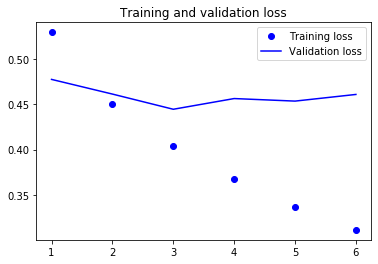

In [23]:
np.random.seed(1)
tf.random.set_seed(1)
model_2_1 = buildModel_2(embedding_matrix_notStemmed, trainable = False)

checkpoint_2_1 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_2_1.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_2_1 = modelCompiler(model_2_1, checkpoint_2_1,
                            [x1_notStemmed_train_split, x2_notStemmed_train_split], labels_train_split,
                            [x1_notStemmed_val_split, x2_notStemmed_val_split], labels_val_split)

result_2_1 = modelTester('model_2_1.h5', [x1_notStemmed_test, x2_notStemmed_test], labels_test)

lossPlot(history_2_1)

## Model 2.2: 'trainable = False' + stemmed data

Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 12s 41us/step - loss: 0.5445 - val_loss: 0.4938
For this epoch: 
Macro F1 score: 0.724126309493097 ---Precision: 0.7290341665434107 ---Recall: 0.5572009947999096
Epoch 2/40
300000/300000 [==============================] - 9s 32us/step - loss: 0.4625 - val_loss: 0.4610
For this epoch: 
Macro F1 score: 0.7564051877662027 ---Precision: 0.7328096832346124 ---Recall: 0.6433416233325797
Epoch 3/40
300000/300000 [==============================] - 10s 32us/step - loss: 0.4122 - val_loss: 0.4509
For this epoch: 
Macro F1 score: 0.7671481274050163 ---Precision: 0.7273055622441609 ---Recall: 0.6829075288265883
Epoch 4/40
300000/300000 [==============================] - 12s 40us/step - loss: 0.3722 - val_loss: 0.4622
For this epoch: 
Macro F1 score: 0.7692414684106859 ---Precision: 0.6935195882785422 ---Recall: 0.7464390685055392
Epoch 5/40
300000/300000 [==============================] -

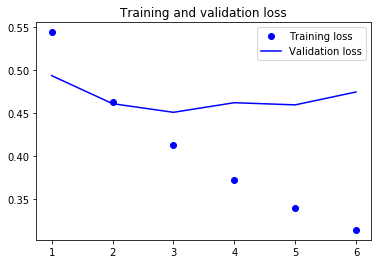

In [24]:
np.random.seed(1)
tf.random.set_seed(1)
model_2_2 = buildModel_2(embedding_matrix_stemmed, trainable = False)

checkpoint_2_2 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_2_2.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_2_2 = modelCompiler(model_2_2, checkpoint_2_2,
                            [x1_stemmed_train_split, x2_stemmed_train_split], labels_train_split,
                            [x1_stemmed_val_split, x2_stemmed_val_split], labels_val_split)

result_2_2 = modelTester('model_2_2.h5', [x1_stemmed_test, x2_stemmed_test], labels_test)

lossPlot(history_2_2)

## Model 2.3: 'trainable = True' + notStemmed data

D:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 17s 57us/step - loss: 0.5190 - val_loss: 0.4612
For this epoch: 
Macro F1 score: 0.7550300355272732 ---Precision: 0.7206467661691542 ---Recall: 0.6549853040922451
Epoch 2/40
300000/300000 [==============================] - 15s 48us/step - loss: 0.4321 - val_loss: 0.4322
For this epoch: 
Macro F1 score: 0.7805967981393509 ---Precision: 0.7349243306169965 ---Recall: 0.7136558896676464
Epoch 3/40
300000/300000 [==============================] - 16s 54us/step - loss: 0.3792 - val_loss: 0.4218
For this epoch: 
Macro F1 score: 0.7891530110335612 ---Precision: 0.7222460351478782 ---Recall: 0.7619262943703369
Epoch 4/40
300000/300000 [==============================] - 16s 54us/step - loss: 0.3324 - val_loss: 0.4339
For this epoch: 
Macro F1 score: 0.7849869083310207 ---Precision: 0.7324501811594203 ---Recall: 0.7312909789735473
Epoch 5/40
300000/300000 [==============================]

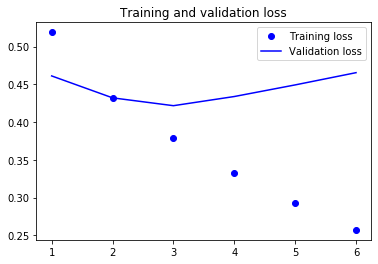

In [25]:
np.random.seed(1)
tf.random.set_seed(1)
model_2_3 = buildModel_2(embedding_matrix_notStemmed, trainable = True)

checkpoint_2_3 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_2_3.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_2_3 = modelCompiler(model_2_3, checkpoint_2_3,
                            [x1_notStemmed_train_split, x2_notStemmed_train_split], labels_train_split,
                            [x1_notStemmed_val_split, x2_notStemmed_val_split], labels_val_split)

result_2_3 = modelTester('model_2_3.h5', [x1_notStemmed_test, x2_notStemmed_test], labels_test)

lossPlot(history_2_3)

## Model 2.4: 'trainable = True' + stemmed data

D:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 19s 62us/step - loss: 0.5272 - val_loss: 0.4677
For this epoch: 
Macro F1 score: 0.7517390731613787 ---Precision: 0.7240321962437716 ---Recall: 0.6406285326701334
Epoch 2/40
300000/300000 [==============================] - 16s 53us/step - loss: 0.4375 - val_loss: 0.4389
For this epoch: 
Macro F1 score: 0.7781620308091417 ---Precision: 0.7466960352422908 ---Recall: 0.6898033009269726
Epoch 3/40
300000/300000 [==============================] - 18s 59us/step - loss: 0.3822 - val_loss: 0.4249
For this epoch: 
Macro F1 score: 0.7871196108237561 ---Precision: 0.7648159700561448 ---Recall: 0.6929685733664933
Epoch 4/40
300000/300000 [==============================] - 18s 60us/step - loss: 0.3328 - val_loss: 0.4340
For this epoch: 
Macro F1 score: 0.7889263003051856 ---Precision: 0.7638271604938272 ---Recall: 0.6994121636898033
Epoch 5/40
300000/300000 [==============================]

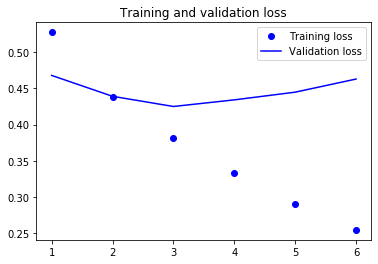

In [26]:
np.random.seed(1)
tf.random.set_seed(1)
model_2_4 = buildModel_2(embedding_matrix_stemmed, trainable = True)

checkpoint_2_4 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_2_4.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_2_4 = modelCompiler(model_2_4, checkpoint_2_4,
                            [x1_stemmed_train_split, x2_stemmed_train_split], labels_train_split,
                            [x1_stemmed_val_split, x2_stemmed_val_split], labels_val_split)

result_2_4 = modelTester('model_2_4.h5', [x1_stemmed_test, x2_stemmed_test], labels_test)

lossPlot(history_2_4)

In [27]:
# Calculate the results and plot the P-R curves.
# Please note that the AUC values on the P-R curves are manully added.
model_2_1_trained = tf.keras.models.load_model('model_2_1.h5')
labels_pred_2_1 = model_2_1_trained.predict([x1_notStemmed_test, x2_notStemmed_test])
precision_2_1, recall_2_1, thresholds_2_1 = precision_recall_curve(labels_test, labels_pred_2_1)

model_2_2_trained = tf.keras.models.load_model('model_2_2.h5')
labels_pred_2_2 = model_2_2_trained.predict([x1_stemmed_test, x2_stemmed_test])
precision_2_2, recall_2_2, thresholds_2_2 = precision_recall_curve(labels_test, labels_pred_2_2)

model_2_3_trained = tf.keras.models.load_model('model_2_3.h5')
labels_pred_2_3 = model_2_3_trained.predict([x1_notStemmed_test, x2_notStemmed_test])
precision_2_3, recall_2_3, thresholds_2_3 = precision_recall_curve(labels_test, labels_pred_2_3)

model_2_4_trained = tf.keras.models.load_model('model_2_4.h5')
labels_pred_2_4 = model_2_4_trained.predict([x1_stemmed_test, x2_stemmed_test])
precision_2_4, recall_2_4, thresholds_2_4 = precision_recall_curve(labels_test, labels_pred_2_4)

In [28]:
print(auc(recall_2_1, precision_2_1))
print(auc(recall_2_2, precision_2_2))
print(auc(recall_2_3, precision_2_3))
print(auc(recall_2_4, precision_2_4))

0.7963720460264241
0.7832224058783986
0.8145877592718124
0.8115242576940271


D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


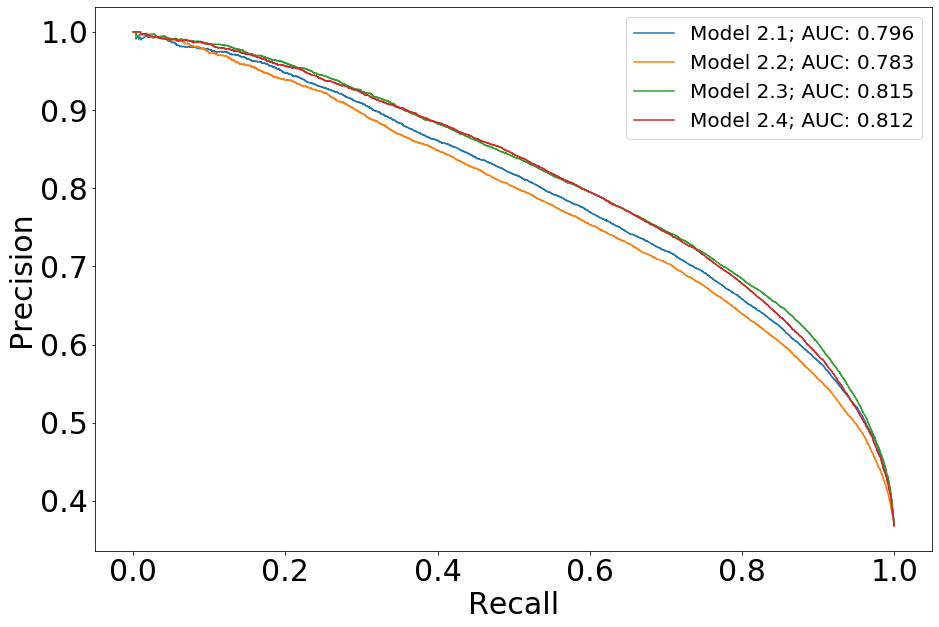

In [29]:
plt.figure(figsize = (15, 10))
plt.plot(recall_2_1, precision_2_1, label = 'Model 2.1; AUC: 0.796')
plt.plot(recall_2_2, precision_2_2, label = 'Model 2.2; AUC: 0.783')
plt.plot(recall_2_3, precision_2_3, label = 'Model 2.3; AUC: 0.815')
plt.plot(recall_2_4, precision_2_4, label = 'Model 2.4; AUC: 0.812')
plt.xlabel('Recall', fontsize = 30)
plt.ylabel('Precision',  fontsize = 30)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.show()

# Model 3

In [30]:
def buildModel_3(embedding_weights, trainable = True):
    embedding = layers.Embedding(max_words, embedding_dim, input_length = maxlen, name = 'Siamese_Embedding')
    lstm = layers.LSTM(32, name = 'Siamese_LSTM')
    
    q1_input = Input(shape=(maxlen, ), name = 'q1_input')
    q1_embedding = embedding(q1_input)
    q1_lstm = lstm(q1_embedding)
    q1_output = q1_lstm
    
    q2_input = Input(shape=(maxlen, ), name = 'q2_input')
    q2_embedding = embedding(q2_input)
    q2_lstm = lstm(q2_embedding)
    q2_output = q2_lstm

    concatenated = layers.concatenate([q1_output, q2_output], axis = -1, name = 'Concatenation')
    concatenated = layers.Dense(200)(concatenated)
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.Activation('relu')(concatenated)
    concatenated = layers.Dropout(0.1)(concatenated)
    concatenated = layers.Dense(200)(concatenated)
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.Activation('relu')(concatenated)
    concatenated = layers.Dropout(0.1)(concatenated)
    concatenated = layers.Dense(200)(concatenated)
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.Activation('relu')(concatenated)
    concatenated = layers.Dropout(0.1)(concatenated)
    y = layers.Dense(1, activation='sigmoid')(concatenated)
    
    model = Model([q1_input, q2_input], y)
    
    model.layers[2].set_weights([embedding_weights])
    
    if trainable == False:
        model.layers[2].trainable = False

    return model
    
buildModel_3(embedding_matrix_notStemmed, trainable = False).summary()
# plot_model(buildModel_3(embedding_matrix_notStemmed))

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_input (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
q2_input (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
Siamese_Embedding (Embedding)   (None, 100, 100)     1000000     q1_input[0][0]                   
                                                                 q2_input[0][0]                   
__________________________________________________________________________________________________
Siamese_LSTM (LSTM)             (None, 32)           17024       Siamese_Embedding[0][0]   

In [31]:
stopping_2 = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    min_delta = 0.01
)

def modelCompiler_2(model, checkpoint, x_train, y_train, x_val, y_val):
    '''
    This function compiles and fits a model, then returns its history.
    '''
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = [])
    history = model.fit(x_train, y_train, epochs = 40, batch_size = 300,
                        validation_data = (x_val, y_val),
                        callbacks = [customMetrics(validation=(x_val, y_val)),
                                     checkpoint,
                                     stopping_2])
    print('Training complete')
    return history

## Model 3.1: 'trainable = False' + notStemmed data

Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 134s 447us/step - loss: 0.5267 - val_loss: 0.4744
For this epoch: 
Macro F1 score: 0.7484189988902532 ---Precision: 0.6787905346187555 ---Recall: 0.7004295726882207
Epoch 2/40
300000/300000 [==============================] - 135s 448us/step - loss: 0.4655 - val_loss: 0.4567
For this epoch: 
Macro F1 score: 0.7633426994167893 ---Precision: 0.6868166526492852 ---Recall: 0.7385258874067375
Epoch 3/40
300000/300000 [==============================] - 133s 443us/step - loss: 0.4440 - val_loss: 0.4412
For this epoch: 
Macro F1 score: 0.7710634008159365 ---Precision: 0.7269612476370511 ---Recall: 0.695568618584671
Epoch 4/40
300000/300000 [==============================] - 133s 445us/step - loss: 0.4288 - val_loss: 0.4387
For this epoch: 
Macro F1 score: 0.7756586488265835 ---Precision: 0.7055050774986639 ---Recall: 0.7460999321727334
Epoch 5/40
300000/300000 [========================

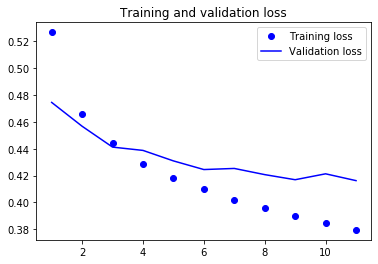

In [32]:
np.random.seed(1)
tf.random.set_seed(1)
model_3_1 = buildModel_3(embedding_matrix_notStemmed, trainable = False)

checkpoint_3_1 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_3_1.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_3_1 = modelCompiler_2(model_3_1, checkpoint_3_1,
                            [x1_notStemmed_train_split, x2_notStemmed_train_split], labels_train_split,
                            [x1_notStemmed_val_split, x2_notStemmed_val_split], labels_val_split)

result_3_1 = modelTester('model_3_1.h5', [x1_notStemmed_test, x2_notStemmed_test], labels_test)

lossPlot(history_3_1)

## Model 3.2: 'trainable = False' + stemmed data

Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 147s 490us/step - loss: 0.5402 - val_loss: 0.4896
For this epoch: 
Macro F1 score: 0.7351591988995774 ---Precision: 0.6570208222103577 ---Recall: 0.695568618584671
Epoch 2/40
300000/300000 [==============================] - 149s 497us/step - loss: 0.4795 - val_loss: 0.4643
For this epoch: 
Macro F1 score: 0.7563348224545463 ---Precision: 0.6908608099136977 ---Recall: 0.7058557540131133
Epoch 3/40
300000/300000 [==============================] - 148s 493us/step - loss: 0.4573 - val_loss: 0.4512
For this epoch: 
Macro F1 score: 0.7634687814185436 ---Precision: 0.7171550094517959 ---Recall: 0.6861858467103775
Epoch 4/40
300000/300000 [==============================] - 147s 491us/step - loss: 0.4428 - val_loss: 0.4452
For this epoch: 
Macro F1 score: 0.7667207811152079 ---Precision: 0.7207876429666313 ---Recall: 0.6910468008139272
Epoch 5/40
300000/300000 [========================

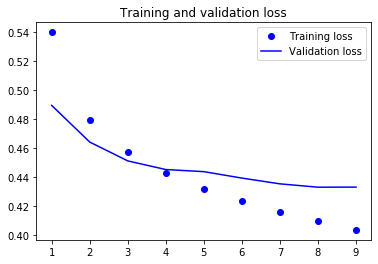

In [33]:
np.random.seed(1)
tf.random.set_seed(1)
model_3_2 = buildModel_3(embedding_matrix_stemmed, trainable = False)

checkpoint_3_2 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_3_2.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_3_2 = modelCompiler_2(model_3_2, checkpoint_3_2,
                              [x1_stemmed_train_split, x2_stemmed_train_split], labels_train_split,
                              [x1_stemmed_val_split, x2_stemmed_val_split], labels_val_split)

result_3_2 = modelTester('model_3_2.h5', [x1_stemmed_test, x2_stemmed_test], labels_test)

lossPlot(history_3_2)

## Model 3.3: 'trainable = True' + notStemmed data

D:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 164s 548us/step - loss: 0.5081 - val_loss: 0.4482
For this epoch: 
Macro F1 score: 0.7664398073684893 ---Precision: 0.7220970228917092 ---Recall: 0.6882206647072123
Epoch 2/40
300000/300000 [==============================] - 166s 554us/step - loss: 0.4279 - val_loss: 0.4220
For this epoch: 
Macro F1 score: 0.7831612682377972 ---Precision: 0.7427591913937818 ---Recall: 0.7102645263395885
Epoch 3/40
300000/300000 [==============================] - 165s 550us/step - loss: 0.3938 - val_loss: 0.4085
For this epoch: 
Macro F1 score: 0.7946733077470418 ---Precision: 0.7259809119830328 ---Recall: 0.773909111462808
Epoch 4/40
300000/300000 [==============================] - 170s 568us/step - loss: 0.3681 - val_loss: 0.4102
For this epoch: 
Macro F1 score: 0.7936335689964171 ---Precision: 0.7743871935967984 ---Recall: 0.6999773909111463
Epoch 5/40
300000/300000 [========================

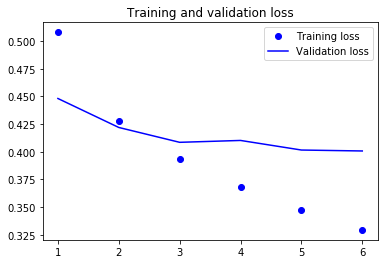

In [34]:
np.random.seed(1)
tf.random.set_seed(1)
model_3_3 = buildModel_3(embedding_matrix_notStemmed, trainable = True)

checkpoint_3_3 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_3_3.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_3_3 = modelCompiler_2(model_3_3, checkpoint_3_3,
                              [x1_notStemmed_train_split, x2_notStemmed_train_split], labels_train_split,
                              [x1_notStemmed_val_split, x2_notStemmed_val_split], labels_val_split)

result_3_3 = modelTester('model_3_3.h5', [x1_notStemmed_test, x2_notStemmed_test], labels_test)

lossPlot(history_3_3)

## Model 3.4: 'trainable = True' + stemmed data

D:\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 300000 samples, validate on 23478 samples
Epoch 1/40
300000/300000 [==============================] - 175s 583us/step - loss: 0.5133 - val_loss: 0.4644
For this epoch: 
Macro F1 score: 0.7623293229355887 ---Precision: 0.6607545045045045 ---Recall: 0.7959529730951843
Epoch 2/40
300000/300000 [==============================] - 176s 586us/step - loss: 0.4307 - val_loss: 0.4604
For this epoch: 
Macro F1 score: 0.7738477814438267 ---Precision: 0.66875 ---Recall: 0.8225186524983044
Epoch 3/40
300000/300000 [==============================] - 170s 567us/step - loss: 0.3954 - val_loss: 0.4088
For this epoch: 
Macro F1 score: 0.7954492602511529 ---Precision: 0.7506334945865009 ---Recall: 0.7367171602984399
Epoch 4/40
300000/300000 [==============================] - 176s 587us/step - loss: 0.3690 - val_loss: 0.4066
For this epoch: 
Macro F1 score: 0.7953183168675999 ---Precision: 0.7722112537018756 ---Recall: 0.7074383902328736
Epoch 5/40
300000/300000 [==============================] - 

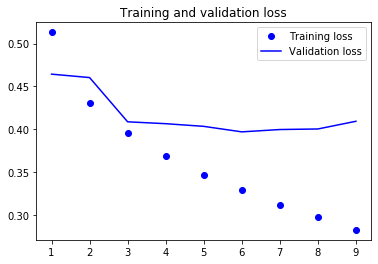

In [35]:
np.random.seed(1)
tf.random.set_seed(1)
model_3_4 = buildModel_3(embedding_matrix_stemmed, trainable = True)

checkpoint_3_4 = keras.callbacks.ModelCheckpoint(
    filepath = 'model_3_4.h5',
    monitor = 'val_loss',
    save_best_only = True
)

history_3_4 = modelCompiler_2(model_3_4, checkpoint_3_4,
                              [x1_stemmed_train_split, x2_stemmed_train_split], labels_train_split,
                              [x1_stemmed_val_split, x2_stemmed_val_split], labels_val_split)

result_3_4 = modelTester('model_3_4.h5', [x1_stemmed_test, x2_stemmed_test], labels_test)

lossPlot(history_3_4)

In [36]:
# Calculate the results and plot the P-R curves.
# Please note that the AUC values on the P-R curves are manully added.
model_3_1_trained = tf.keras.models.load_model('model_3_1.h5')
labels_pred_3_1 = model_3_1_trained.predict([x1_notStemmed_test, x2_notStemmed_test])
precision_3_1, recall_3_1, thresholds_3_1 = precision_recall_curve(labels_test, labels_pred_3_1)

model_3_2_trained = tf.keras.models.load_model('model_3_2.h5')
labels_pred_3_2 = model_3_2_trained.predict([x1_stemmed_test, x2_stemmed_test])
precision_3_2, recall_3_2, thresholds_3_2 = precision_recall_curve(labels_test, labels_pred_3_2)

model_3_3_trained = tf.keras.models.load_model('model_3_3.h5')
labels_pred_3_3 = model_3_3_trained.predict([x1_notStemmed_test, x2_notStemmed_test])
precision_3_3, recall_3_3, thresholds_3_3 = precision_recall_curve(labels_test, labels_pred_3_3)

model_3_4_trained = tf.keras.models.load_model('model_3_4.h5')
labels_pred_3_4 = model_3_4_trained.predict([x1_stemmed_test, x2_stemmed_test])
precision_3_4, recall_3_4, thresholds_3_4 = precision_recall_curve(labels_test, labels_pred_3_4)

In [37]:
print(auc(recall_3_1, precision_3_1))
print(auc(recall_3_2, precision_3_2))
print(auc(recall_3_3, precision_3_3))
print(auc(recall_3_4, precision_3_4))

0.8037178919722145
0.780053104637956
0.827873163121227
0.8381415221086179


D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


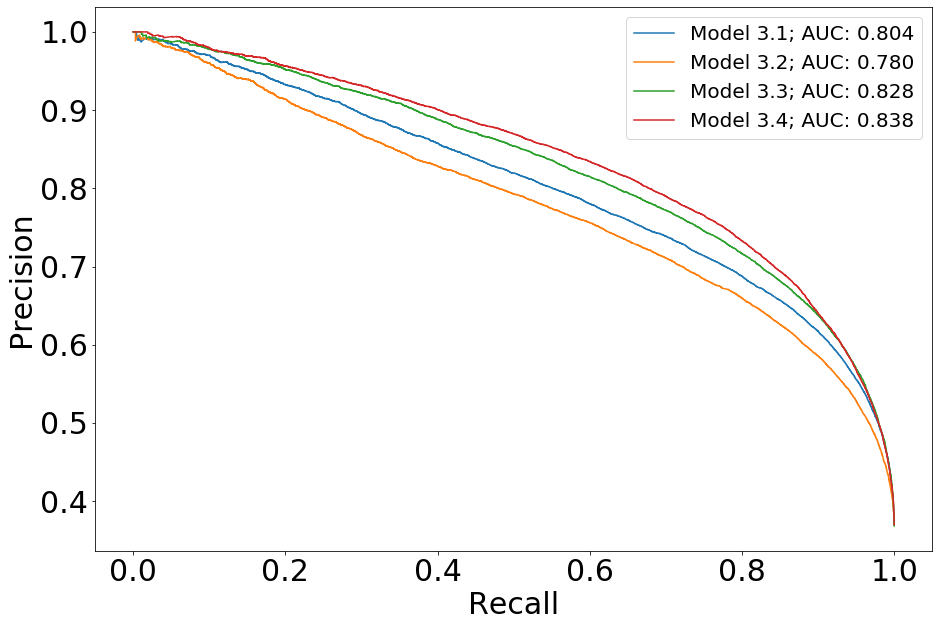

In [38]:
plt.figure(figsize = (15, 10))
plt.plot(recall_3_1, precision_3_1, label = 'Model 3.1; AUC: 0.804')
plt.plot(recall_3_2, precision_3_2, label = 'Model 3.2; AUC: 0.780')
plt.plot(recall_3_3, precision_3_3, label = 'Model 3.3; AUC: 0.828')
plt.plot(recall_3_4, precision_3_4, label = 'Model 3.4; AUC: 0.838')
plt.xlabel('Recall', fontsize = 30)
plt.ylabel('Precision',  fontsize = 30)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.show()

D:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


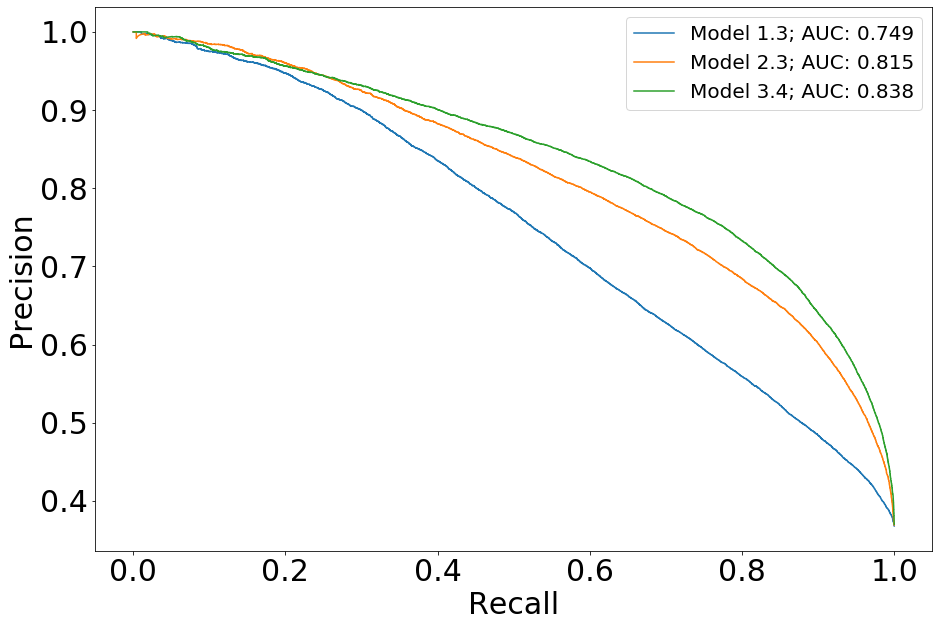

In [39]:
# P-R curves of the best sub-models
plt.figure(figsize = (15, 10))
plt.plot(recall_1_3, precision_1_3, label = 'Model 1.3; AUC: 0.749')
plt.plot(recall_2_3, precision_2_3, label = 'Model 2.3; AUC: 0.815')
plt.plot(recall_3_4, precision_3_4, label = 'Model 3.4; AUC: 0.838')
plt.xlabel('Recall', fontsize = 30)
plt.ylabel('Precision',  fontsize = 30)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.show()